# Displaying different trajectories in their correspoding map
In this jupyter notebook real and synthetic data from the geolife datset will be displayed in order to inspect the propertis in a visual fashion.
The kernel is running on python 3.12.0 and the dependencies are:

- numpy == 1.26.2
- pandas == 2.1.4
- geopandas == 0.14.1
- shapely ==  2.0.2
- matplotlib == 3.8.2
- osmnx == 1.8.0

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, LineString, Point
import matplotlib.pyplot as plt
import osmnx as ox

import os

## Loading the data
The folder is arranged as follows:
- data/
    - gps
    - real.data
    - [epsilon]/
        - gene.data

In which [epsilon]/ is a folder with the value of the epsilon used during training of the model, therefore we can add multiple folders for each epsilon value.

We select the epsilon we want to load and read the three files:
- gps: A file with M gps coordinates that are in any trajectory on the train dataset.
- real.data: A file with N arrays of integers that range from 1 to M. Each integer corresponds to a pair of coordinates that form a real trajectory.
- gene.data: A file with N' arrays of integers that range from 1 to M. Each integer corresponds to a pair of coordinates that form a synthetic trajectory.

In [2]:
epsilon = 20
real_path = os.path.join('data', 'real.data')
gps_path = os.path.join('data', 'gps')
synhtetic_path = os.path.join('data', str(epsilon), 'gene.data')

real_data = pd.read_csv(real_path, delimiter=' ',header=None).T
synth_data = pd.read_csv(synhtetic_path, delimiter=' ', header=None).T
gps = pd.read_csv(gps_path, delimiter=' ', header=None)
CRS = 'epsg:4326'
gps = gpd.GeoDataFrame([], geometry=gpd.points_from_xy(gps[1], gps[0]), crs=CRS)

## Preprocessing
We create a geodataframe for the real trajectories and the synthetic ones. IN this geodataframes the values of each trajectories will be GPS coordinates and not integers. 

In [3]:
real_traj = gpd.GeoDataFrame([],columns=['geometry'], crs=CRS)
for i in range(real_data.shape[1]):
    real_traj.at[i, 'geometry'] = LineString(gps.loc[real_data[i]]['geometry'])
print(real_traj)

                                               geometry
0     LINESTRING (116.34700 39.94100, 116.34800 39.9...
1     LINESTRING (116.18600 40.12400, 116.18600 40.1...
2     LINESTRING (116.33100 39.97600, 116.33100 39.9...
3     LINESTRING (116.41300 39.98700, 116.41300 39.9...
4     LINESTRING (116.33300 39.97500, 116.30400 39.9...
...                                                 ...
6995  LINESTRING (116.43300 40.02700, 116.43300 40.0...
6996  LINESTRING (116.30700 39.98300, 116.30800 39.9...
6997  LINESTRING (116.32500 39.86700, 116.32500 39.8...
6998  LINESTRING (116.32000 39.98500, 116.30700 40.0...
6999  LINESTRING (116.32700 39.98400, 116.32700 39.9...

[7000 rows x 1 columns]


In [4]:
synth_traj = gpd.GeoDataFrame([],columns=['geometry'], crs=CRS)
for i in range(synth_data.shape[1]):
    synth_traj.at[i, 'geometry'] = LineString(gps.loc[synth_data[i]]['geometry'])
print(synth_traj)

                                               geometry
0     LINESTRING (116.33100 39.97500, 116.44900 39.9...
1     LINESTRING (116.32700 40.00000, 116.32700 40.0...
2     LINESTRING (116.31300 39.97900, 116.33100 39.9...
3     LINESTRING (116.32800 40.00000, 116.42500 39.9...
4     LINESTRING (116.30000 39.94000, 116.30000 39.9...
...                                                 ...
9979  LINESTRING (116.33100 39.97500, 116.30400 39.9...
9980  LINESTRING (116.32300 40.00000, 116.32100 39.9...
9981  LINESTRING (116.63300 39.87300, 116.31600 39.9...
9982  LINESTRING (116.44800 39.98000, 115.22800 25.9...
9983  LINESTRING (116.47100 39.90700, 116.47100 39.9...

[9984 rows x 1 columns]


Sometimes we will want to clip the trajectories to certain values in order to limit the range of the graph we want to display. This can be done using the following commands:

In [5]:
polygon = box(37.5, 115.5, 42, 118)
real_clipped = real_traj.clip(polygon)
synth_clipped = synth_traj.clip(polygon)

## Obtaining a map of the terrain
We want to display the trajectories with a map in order to see if they are corrctly bounded by the different elements of the place that have been taken from. For this we use the osmnx library to load graphs of the highway information. For instance we can load the information of the city where the data is from:

In [6]:
city = ox.graph_from_place('Beijing, China', network_type='all',which_result=2)

In our case we want to generalize the code as much as possible, therefore we are calculating the centroid of all the trajectories and plotting all the highway information in a square that has the center in said point and a specified distance in meters. In our case we have defined through experimentation a specific point that will be closer to the first 10 trajectories (the ones we are representing in this example)

In [7]:
real_traj = real_traj.to_crs(crs=CRS)
geom = LineString([x for x in real_traj.centroid])
geom = gpd.GeoDataFrame([geom], columns=['geometry'], crs=CRS)
geom.set_geometry('geometry')

point = (geom.centroid[0].y, geom.centroid[0].x)
print(point)
point = 39.91, 116.36
square = ox.graph_from_point(center_point=point, network_type='all', dist=90000)

/tmp/ipykernel_11115/3845676730.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geom = LineString([x for x in real_traj.centroid])
/tmp/ipykernel_11115/3845676730.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point = (geom.centroid[0].y, geom.centroid[0].x)


(38.289106460145405, 98.90504269636926)


If we want we can modify the format of the graph to a GeoDataFrame, the object used in the geopandas library, but we have to keep in mind that two dataframes are generated: one with nodes, and another with edges.

In [8]:
square_gdf = ox.graph_to_gdfs(square)
for gdf in square_gdf:
    gdf.set_crs(epsg=4326, allow_override=True, inplace=True)

square_gdf

(                     y           x          highway  street_count  ref  \
 osmid                                                                    
 267786371    39.120913  117.196458  traffic_signals             4  NaN   
 267786377    39.124736  117.202213              NaN             4  NaN   
 267786389    39.127985  117.197435  traffic_signals             4  NaN   
 267786396    39.127965  117.194628              NaN             3  NaN   
 267786422    39.128981  117.181827              NaN             3  NaN   
 ...                ...         ...              ...           ...  ...   
 11385539235  40.351779  115.527982              NaN             3  NaN   
 11393311466  40.331592  115.579954              NaN             3  NaN   
 11393404570  40.328126  115.578248              NaN             3  NaN   
 11393404571  40.331283  115.581356              NaN             3  NaN   
 11393404576  40.328306  115.580940              NaN             3  NaN   
 
                       

## Plotting trajectories
Finally we can plot both datasets in our selected map. First we create a subplot with the size we want, and then in said subplot we can represent the real trajectories and the graph (or the gdf of the graph). IN this scenario we plot a small amount of trajectories because we could not see anything on the map otherwise.

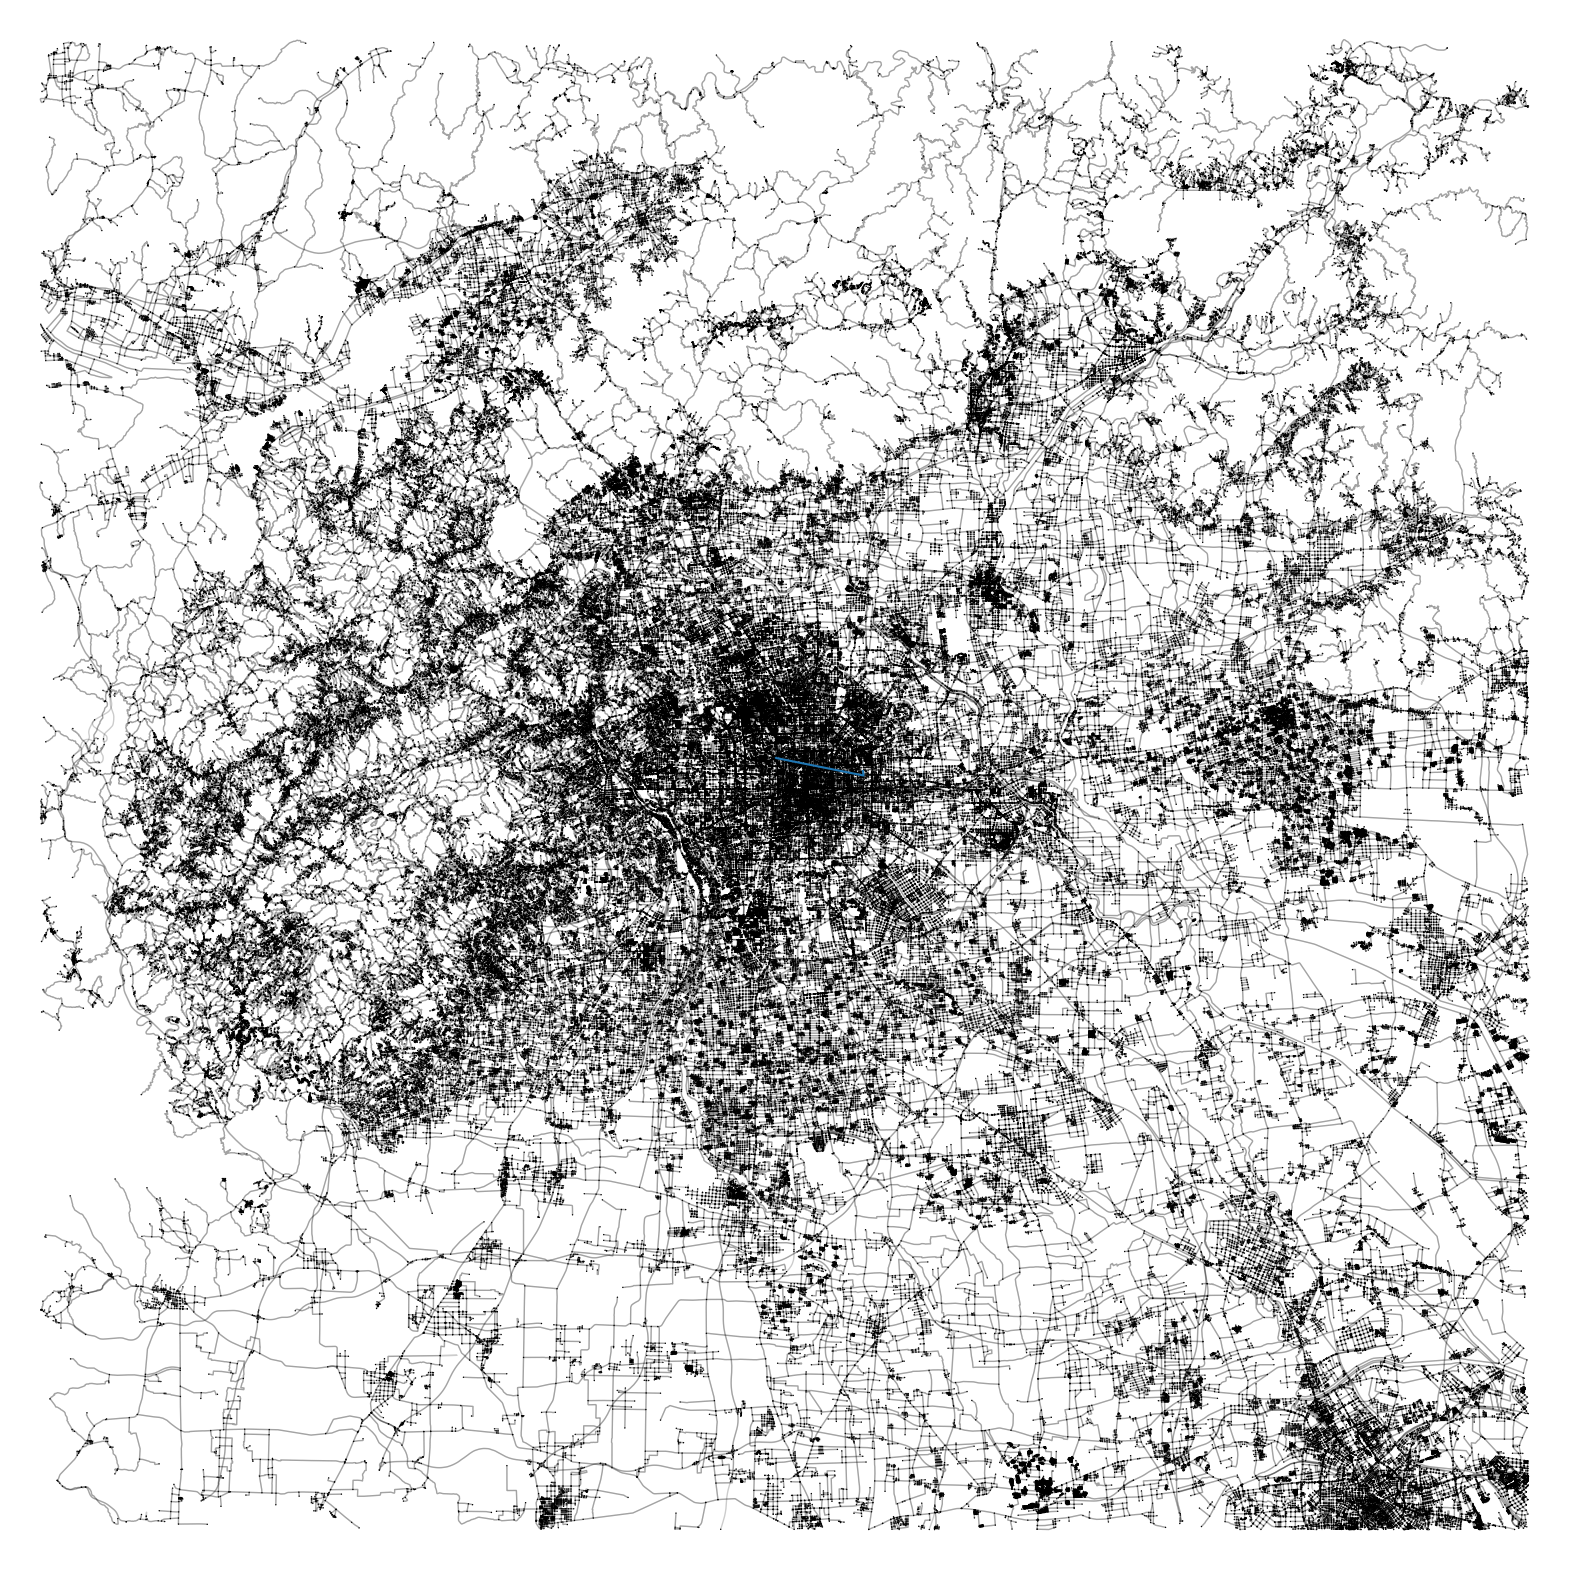

In [16]:
fig, (ax1) = plt.subplots(1,1, figsize=(20,40))

real_traj[0:1].plot(ax=ax1, aspect='equal', alpha=1)

#square_gdf[1]['geometry'].plot(ax=ax1, color='black', aspect='equal', alpha=0.2)
ox.plot_graph(square, ax=ax1, edge_color='black', node_color='black', node_size=1, edge_alpha=0.2)
plt.show()

Here we replicate the same for the synthetic dataset

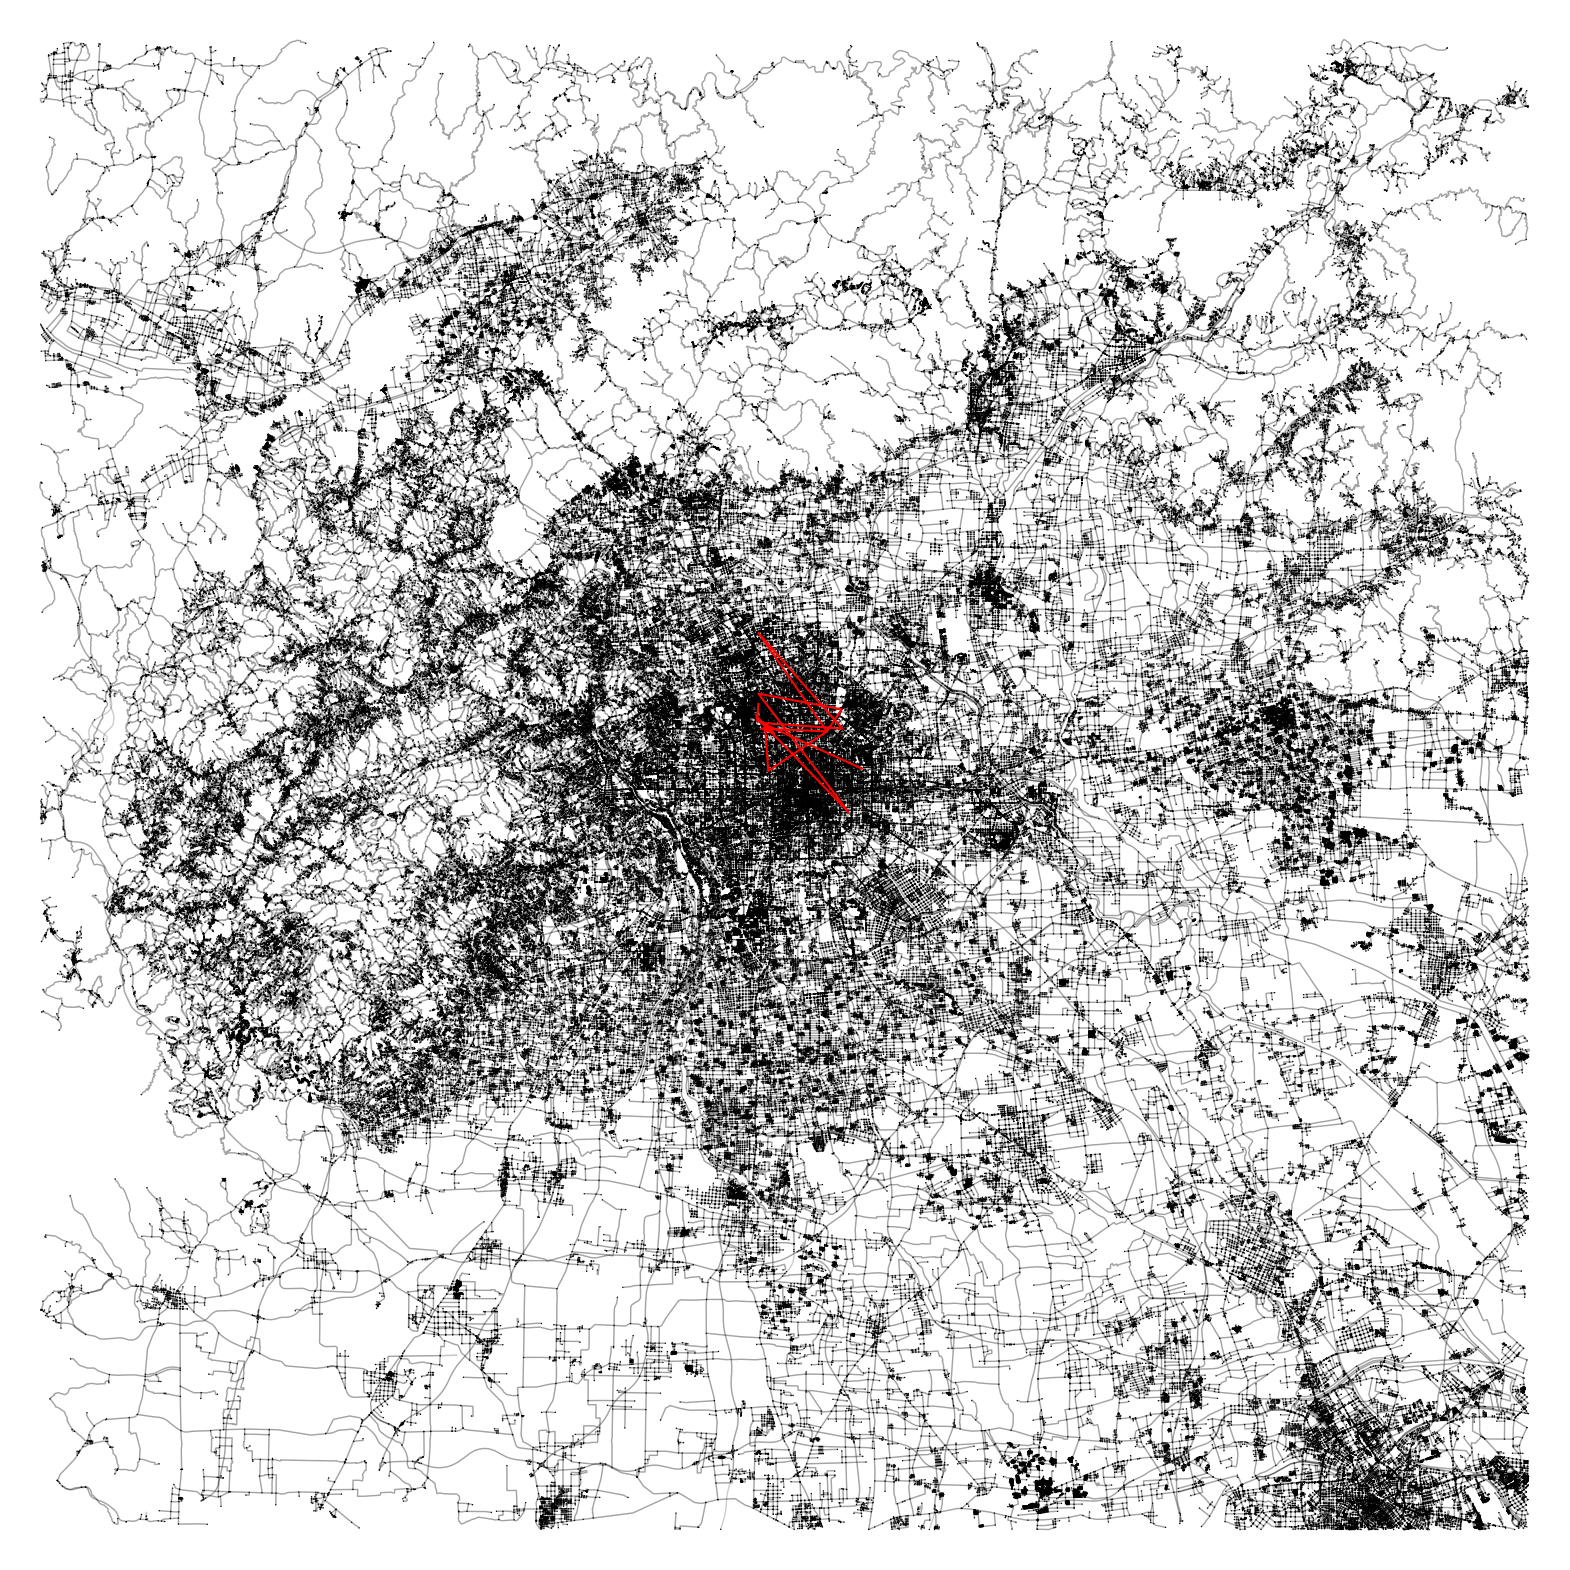

In [18]:
fig, (ax2) = plt.subplots(1,1, figsize=(20,40))
synth_traj[9980:9981].plot(ax=ax2, color='red', alpha=1)

#square_gdf[1]['geometry'].plot(ax=ax2, color='black', aspect='equal', alpha=0.5)
ox.plot_graph(square, ax=ax2, edge_color='black', node_color='black', node_size=1, edge_alpha=0.2)
plt.show()

In [69]:
def trajDifference(gdf: LineString, other: LineString) -> LineString :
    dif = []
    for a, b in zip(gdf.coords, other.coords):
        a = Point(a)
        b = Point(b)
        p = pointDifference(a,b)
        dif.append(p)
    return LineString(dif)

def pointDifference(a:Point, b:Point)->Point:
    x, y= b.x-a.x, b.y-a.y
    return Point(x,y)

diff=[]
for real, synth in zip(real_traj.values, synth_traj.values):
    diff.append(trajDifference(real[0], synth[0]))

diff = gpd.GeoDataFrame([], geometry=diff)